# **Israel Elections Data Analysis - Lab 7**


**Daniel Ohayon - ID: 315453027**

**Olga Moroz - ID: 324756568**

### **Import modules**

In [1]:
import numpy as np  # a module for working with numerical array 
import pandas as pd  # a module for working with data-frames
import math
import os
import io
from matplotlib import pyplot as plt
import numpy.matlib as mtl
import copy
import random
import statsmodels.api as sm
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Import data**

In [2]:
# Mount drive in google colab
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
# Loading elections 2020 elections data:
from google.colab import files
uploaded = files.upload()


Saving Eshkol Hevrati Calcali.csv to Eshkol Hevrati Calcali.csv
Saving votes per ballot 2019b.csv to votes per ballot 2019b.csv
Saving votes per ballot 2020.csv to votes per ballot 2020.csv
Saving votes per city 2019b.csv to votes per city 2019b.csv
Saving votes per city 2020.csv to votes per city 2020.csv


In [4]:
df_2020_ballot_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2020.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
df_2020_ballot_raw = df_2020_ballot_raw.drop(['מעטפות חיצוניות'], axis=0)
df_2019_ballot_raw = pd.read_csv(io.BytesIO(uploaded['votes per ballot 2019b.csv']),  encoding = 'iso-8859-8', index_col='שם ישוב')
df_2019_ballot_raw = df_2019_ballot_raw.drop(['מעטפות חיצוניות'], axis=0)


In [5]:
df_2020_ballot_raw 

,סמל ועדה,ברזל,סמל ישוב,קלפי,ריכוז,שופט,בזב,מצביעים,פסולים,כשרים,אמת,ג,ודעם,ז,זך,זץ,טב,י,יז,ינ,יף,יק,יר,כ,כן,ל,מחל,נ,נז,ני,נץ,נק,פה,ףז,ץ,ק,קי,קך,קץ,שס
שם ישוב,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
אבו גווייעד שבט,18,9870,967,1.0,1,0,585,126,2,124,2,0,112,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,6,1,0,0,0,0,0,2
אבו גווייעד שבט,18,9871,967,2.0,1,0,764,249,2,247,6,0,235,0,0,0,0,0,0,0,0,0,0,0,1,0,2,0,1,0,0,0,0,0,0,0,0,0,2,0
אבו גווייעד שבט,18,9872,967,3.0,1,0,669,220,2,218,5,0,207,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,2,1,0,0,0,0,0,0
אבו גוש,2,736,472,1.0,1,0,530,299,7,292,15,1,229,0,0,0,0,0,0,1,0,0,1,0,0,0,32,0,0,0,0,0,11,0,0,0,0,0,0,2
אבו גוש,2,737,472,2.0,1,0,693,388,6,382,6,0,330,0,0,0,0,0,0,2,0,0,0,0,0,2,23,0,0,0,0,0,18,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
תקוע,2,1050,3563,2.0,3,0,672,496,1,495,10,14,2,3,0,0,174,0,0,0,0,0,0,1,1,15,227,0,0,0,9,0,27,0,0,0,0,1,0,11
תקוע,2,1051,3563,3.0,3,0,725,572,1,571,7,8,0,1,0,0,301,0,0,0,0,0,0,0,0,10,188,2,0,0,9,0,25,1,0,1,0,1,4,13
תראבין אצאנע שבט,18,10069,970,1.0,1,0,520,48,0,48,0,0,43,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0


In [6]:
df_2019_ballot_raw['אמת'] = df_2019_ballot_raw['אמת'] + df_2019_ballot_raw['מרצ']
df_2019_ballot_raw = df_2019_ballot_raw.drop(['מרצ'], axis=1)

**:בניית מילון לשמות המפלגות**

In [7]:
party_dict = { "מחל" : "הליכוד", "פה" : "כחול לבן", "ודעם" : "הרשימה המשותפת" , "שס" : "שס" ,
               "ג" : "יהדות התורה", "ל" : "ישראל ביתנו", "אמת" :  "העבודה גשר מרצ",  "טב" : "ימינה" }

par_names = list(party_dict.values())

מחיקת עמודות לא רלוונטיות

In [8]:
df_2020_8par = df_2020_ballot_raw[party_dict] # removing "metadata" columns
df_2019_8par = df_2019_ballot_raw[party_dict] # removing "metadata" columns

קביעת שמות העמודות כשמות המפלגות

In [9]:
df_2020_8par.columns = df_2020_8par.columns.to_series().map(party_dict)
df_2019_8par.columns = df_2019_8par.columns.to_series().map(party_dict)

# **Q.1 :**

### **A**

חישוב אומדן לשכיחות ההצבעה על ידי בחירת 10 קלפיות אקראיות 100 פעמים

In [10]:
sample = []
pj_hat = []
for i in range(100):
    random.seed(i)
    s = df_2020_8par.iloc[random.sample(range(df_2020_8par.shape[0]), 10)]
    sample.append(s)
    pj_hat.append(s.sum(axis = 0).div(s.sum(axis = 1).sum()))
rand_samp = pd.concat(sample)
pj_hat =  pd.DataFrame(pj_hat)

In [11]:
pj_hat

,הליכוד,כחול לבן,הרשימה המשותפת,שס,יהדות התורה,ישראל ביתנו,העבודה גשר מרצ,ימינה
0,0.304149,0.284437,0.013752,0.139354,0.038506,0.055466,0.065093,0.099244
1,0.277576,0.236723,0.213118,0.051748,0.061961,0.065365,0.066500,0.027009
2,0.266303,0.331763,0.222663,0.030002,0.007191,0.033474,0.087280,0.021324
3,0.180961,0.251178,0.392083,0.032045,0.006126,0.032516,0.066211,0.038878
4,0.207235,0.217054,0.220155,0.124806,0.106718,0.037209,0.062532,0.024289
...,...,...,...,...,...,...,...,...
95,0.345107,0.193795,0.098329,0.139141,0.052029,0.095704,0.048449,0.027446
96,0.251905,0.151854,0.288217,0.087862,0.075673,0.085322,0.035043,0.024124
97,0.226261,0.204202,0.212395,0.128992,0.131092,0.030462,0.031092,0.035504
98,0.289654,0.350501,0.003646,0.059480,0.095943,0.088879,0.075205,0.036691


In [ ]:
pj_hat.mean()

### **B**

חישוב השכיחות האמיתית

In [ ]:
pj = df_2020_8par.sum(axis = 0).div(df_2020_8par.sum(axis = 1).sum())
pj

חישוב הטיה

In [14]:
bias = pj_hat.mean() - pj
bias

הליכוד            0.005757
כחול לבן         -0.003494
הרשימה המשותפת    0.001247
שס               -0.002695
יהדות התורה      -0.003339
ישראל ביתנו       0.000716
העבודה גשר מרצ   -0.000245
ימינה             0.002054
dtype: float64

**ניתן לראות שההטיה אכן קרובה ל-0**

חישוב שונות

In [15]:
var = pj_hat.var(axis = 0)
var

הליכוד            0.004466
כחול לבן          0.004546
הרשימה המשותפת    0.011579
שס                0.001018
יהדות התורה       0.002961
ישראל ביתנו       0.000558
העבודה גשר מרצ    0.000474
ימינה             0.000894
dtype: float64

חישוב השגיאה הריבועית

In [16]:
mse = (var + (bias**2))
mse

הליכוד            0.004499
כחול לבן          0.004558
הרשימה המשותפת    0.011581
שס                0.001025
יהדות התורה       0.002972
ישראל ביתנו       0.000559
העבודה גשר מרצ    0.000475
ימינה             0.000898
dtype: float64

חישוב סטיית התקן עבור הגרף

In [ ]:
std = pj_hat.std(axis = 0)

### **C**

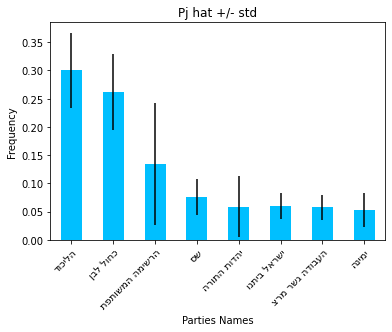

In [19]:
std = pj_hat.std(axis = 0)
fig, ax = plt.subplots()
pj_hat.mean().plot(kind='bar', yerr=std, color='deepskyblue')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")
ax.set_xticklabels([name[::-1] for name in list(par_names)])
ax.set_ylabel('Frequency')
ax.set_xlabel('Parties Names')
ax.set_title('Pj hat +/- std')
plt.show()

### **D**

חישוב השגיאה הריבועית התיאורטית

In [20]:
mse_t = (pj * (1- pj))/(rand_samp.sum().sum()/100)
mse_t

הליכוד            0.000052
כחול לבן          0.000048
הרשימה המשותפת    0.000029
שס                0.000018
יהדות התורה       0.000014
ישראל ביתנו       0.000014
העבודה גשר מרצ    0.000013
ימינה             0.000012
dtype: float64

השוואה בין השגיאות הריבועיות

In [21]:
def bar_plot(var1, var2, title1, title2):
  width = 0.2
  fig, ax = plt.subplots()  # plt.subplots()
  rev_names = [name[::-1] for name in list(var1.index)]
  bar1 = ax.bar(np.arange(8)- width, list(var1), width, color='g')
  bar2 = ax.bar(np.arange(8) , list(var2), width, color='r')

  ax.set_ylabel('Frequency')
  ax.set_xlabel('Parties Names')
  ax.legend((bar1[0], bar2[0]), (title1, title2))
  ax.set_xticks(np.arange(8))
  plt.setp(ax.get_xticklabels(), rotation=60, ha="right",rotation_mode="anchor")
  ax.set_xticklabels(rev_names)
  plt.show()
  return fig, ax


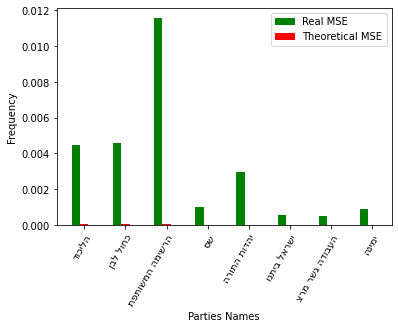

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf7d4bc7f0>)

In [22]:
bar_plot(mse,mse_t,"Real MSE","Theoretical MSE")

# **Q2.**

### **A**

איחוד קובץ האשכולות החברתיים עם נתוני הבחירות

In [23]:
eshkol = pd.read_csv('Eshkol Hevrati Calcali.csv')

In [ ]:
df_2020_8par_tmp= df_2020_8par
df_2020_8par_tmp["set_code"] =  df_2020_ballot_raw['סמל ישוב']
df_2020_8par_tmp['כשרים'] = df_2020_ballot_raw["כשרים"]
df_2020_8par_esh = pd.merge(df_2020_8par_tmp, eshkol,on='set_code')
df_2020_8par_esh = df_2020_8par_esh.drop(['population','index_value'],axis = 1)


### **B**

חישוב אומדן לשכיחות ההצבעה על ידי בחירת קלפי אקראית מכל אשכול

In [25]:
pj_hat_esh = pd.DataFrame()
sum_votes_eshkol = []

for i in range(1,11):
  data_new = pd.DataFrame(df_2020_8par_esh.where(df_2020_8par_esh["eco_level"] == i))
  data_new = data_new.dropna()
  data_8 = data_new[par_names]
  eco = data_8.iloc[random.sample(range(data_8.shape[0]),1)]
  pj_hat_esh = pd.concat([pj_hat_esh,eco])
  sum_votes_eshkol.append(data_new.sum()["כשרים"])

pj_hat_esh = pj_hat_esh.div(pj_hat_esh.sum(axis = 1),axis=0)
pj_hat_esh.index = [1,2,3,4,5,6,7,8,9,10]

אומדן לשכיחות ההצבעה לכל מפלגה לפי כל אשכול

In [ ]:
pj_hat_esh                # votes for party j in eco l

חישוב אומדן משוקלל לכל האשכולות

In [27]:
sum_votes_eshkol = sum_votes_eshkol/sum(sum_votes_eshkol)

In [28]:
pj_hat_w = (pj_hat_esh.multiply(sum_votes_eshkol,axis =0)).sum()
pj_hat_w 

הליכוד            0.246656
כחול לבן          0.323800
הרשימה המשותפת    0.162593
שס                0.018220
יהדות התורה       0.004337
ישראל ביתנו       0.120219
העבודה גשר מרצ    0.094648
ימינה             0.029527
dtype: float64

### **C**

חישוב הדגימה לפי אשכולות 100 פעמים

In [29]:
all_pj_hat = pd.DataFrame()
pj_hat_esh= pd.DataFrame()
votes_eshkol = []

for sim in range(100):
  random.seed(sim)
  for i in range(1,11):
    data_new = pd.DataFrame(df_2020_8par_esh.where(df_2020_8par_esh["eco_level"] == i))
    data_new = data_new.dropna()
    data_8 = data_new[par_names]
    eco = data_8.iloc[random.sample(range(data_8.shape[0]),1)]
    pj_hat_esh = pd.concat([pj_hat_esh,eco])
    votes_eshkol.append(data_new.sum()["כשרים"])
  votes_eshkol = votes_eshkol/sum(votes_eshkol)
  pj_hat_esh = pj_hat_esh.div(pj_hat_esh.sum(axis = 1),axis=0)
  pj_hat_w = pd.DataFrame((pj_hat_esh.multiply(sum_votes_eshkol,axis =0)).sum())
  pj_hat_w = pj_hat_w.T
  all_pj_hat = pd.concat([all_pj_hat, pj_hat_w])
  pj_hat_esh = pd.DataFrame()
  votes_eshkol = []
   

חישוב השגיאה הריבועית במדגם זה

In [30]:
mse_100 = 0
for i in range (100):
    mse_100 += (all_pj_hat.iloc[i]-pj)**2
mse_100 = mse_100/100

In [ ]:
mse_100

השוואה בין השגיאות הריבועיות בשתי השיטות

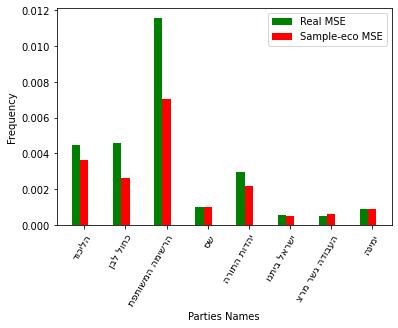

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf7d40bac8>)

In [32]:
bar_plot(mse, mse_100,"Real MSE","Sample-eco MSE")

סכום השגיאה הריבועית בשתי השיטות

In [33]:
mse.sum(), mse_100.sum()

(0.02656600393245151, 0.018641280400509587)

ניתן לראות שהשגיאה הריבועית ממדגם השכבות היא יותר קטנה ולכן נעדיף את השיטה הזאת.

# **Q3.**

### **A**

חישוב qj

In [34]:
qj = df_2019_8par.sum(axis=0).div(df_2019_8par.sum(axis=1).sum())

**בניית פונקציות לחישוב שונות, הטייה ושגיאה ריבועית בהינתן אלפא**




In [35]:
def calc_bias_2(alpha):
    bias_new = ((1 - alpha) * (pj_hat.mean() - qj))**2
    return bias_new

def calc_var(alpha):
    var_new = (alpha ** 2) * var
    return var_new

def calc_mse(alpha, var, bias_2):
    mse_new = var + (bias_2)
    return mse_new

הפעלת הפונקציות על כל האלפות הנדרשות

In [36]:
all_bias, all_var, all_mse = [], [], []
for i in np.arange(0, 1.01, 0.01):
  all_bias.append(calc_bias_2(i))
  all_var.append(calc_var(i))
  all_mse.append(calc_mse(i, all_var[-1],all_bias[-1]))

גרף מחולק לכל מפלגה עם הממצאים

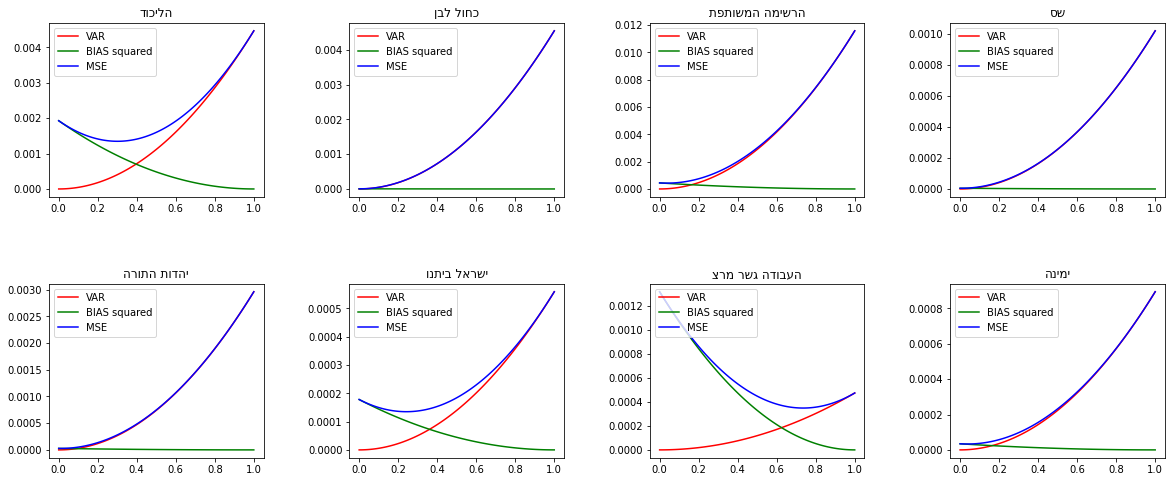

In [37]:
alpha_range = np.arange(0, 1.01, 0.01)
count = 0 
fig, ax = plt.subplots(2,4, figsize=(20,8))
fig.subplots_adjust(hspace = 0.5, wspace = 0.4)
for i in range(2):
    for j in range(4):
        name = par_names[count]
        rev_name = name[::-1]
        var_plot = (np.array(all_var))[:,count]
        bias_plot = (np.array(all_bias))[:,count]
        mse_plot = (np.array(all_mse))[:,count]
        ax[i,j].plot(alpha_range,var_plot,'r',label='VAR')
        ax[i,j].plot(alpha_range,bias_plot,'g',label='BIAS squared')
        ax[i,j].plot(alpha_range,mse_plot,'b',label='MSE')
        ax[i,j].legend(loc='upper left')
        ax[i,j].set_title(rev_name)
        count += 1
plt.show()

השוואה בין אלפה ששוה 1 לאלפא ששווה 0.5

In [38]:
var_05 =calc_var(0.5)
bias_05 = calc_bias_2(0.5)

var_1 =calc_var(1)
bias_1 = calc_bias_2(1)

mse_05 = calc_mse(0.5,var_05,bias_05)
mse_1 = calc_mse(1,var_1,bias_1)


In [44]:
mse_05.mean() , mse_1.mean()

(0.0009510599135899617, 0.0033119866815224416)

ניתן לראות שאכן השגיאה הריבועית הממוצעת משתפרת כאשר אלפא שווה 0.5 ביחס לאלפא ששווה 1

### **B**

mse_pj_bar = [(1 - alpha) * (pj_hat - qj)] ^2 + [(alpha ^ 2) * var(pj_hat)]

the first derivative is: 2 * alpha * var * var(pj_hat) - 2*(1 - alpha) * (qj - pj_hat)
^2 

נשווה את הביטוי הנ"ל ל-0 ונקבל את האלפא שממזערת את השגיאה הריבועית

alpha = [(qj-pj_hat)^2] / [(var(pj_hat) + ((qj - pj_hat)^2]

ניתן לראות שהנגזרת השנייה חיובית ולכן זו נקודות מינימום כנדרש

In [41]:
min_alpha = ((qj - pj_hat.mean())**2) / (var + (qj - pj_hat.mean())**2)
min_alpha

הליכוד            0.301460
כחול לבן          0.000918
הרשימה המשותפת    0.036873
שס                0.004453
יהדות התורה       0.009234
ישראל ביתנו       0.241544
העבודה גשר מרצ    0.735398
ימינה             0.037199
dtype: float64

השוואה בין השגיאות הריבועיות של כל אלפא

In [42]:
var_min =calc_var(min_alpha)
bias_min = calc_bias_2(min_alpha)
mse_min= calc_mse(min_alpha, var_min, bias_min)

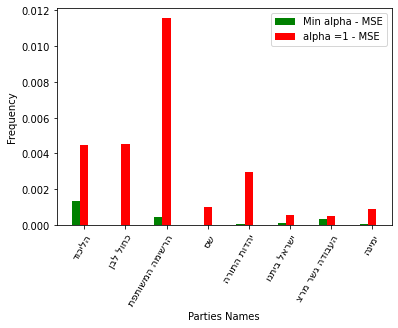

(<Figure size 432x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fcf7cf44630>)

In [43]:
bar_plot(mse_min, mse_1,"Min alpha - MSE","alpha =1 - MSE")

ניתן לראות שהאלפא המינימלית אכן ממזערת את השגיאה הריבועית הממוצעת של כל מפלגה.

אבל לא ניתן לקבוע שהאומדן הזה הוא תמיד יותר טוב מכיוון שהביטוי של אלפא תלוי בתוצאות האמת ואינו קבוע ולכן טיב האומדן ישתנה בכל בחירות.